<a href="https://colab.research.google.com/github/viriditass/TIL/blob/main/Attention_Is_All_You_Need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transformer는 자연어처리에서 가장 중요한 논문이라고 생각이 됩니다. 이유는 2019년 12월 현재 각종 Benchmark 에서 가장 좋은 성능을 내고 있는 모델들이 Transformer 기반의 Pretrained 모델이기 때문 입니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/My Drive/Kowiki"

Mounted at /content/drive


In [2]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 2.7MB/s 


In [3]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import sentencepiece as spm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
for i in os.listdir(data_dir):
  print(i)

kowiki.model
kowiki.vocab
kowiki.csv.gz
ratings_test.json
ratings_test.txt
ratings_train.json
ratings_train.txt


## 1. Vocab
이미 만들어 놓은 vocab을 이용해 텍스트를 입력 tensor로 변경합니다.

In [5]:
# vocab loading
vocab_file = f"{data_dir}/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# 입력 texts
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]

# text를 tensor로 변환
inputs = []
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  inputs.append(torch.tensor(ids))
  print(pieces)

# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
# shape
print(inputs.size())
# 값
print(inputs)

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']
torch.Size([2, 8])
tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
        [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]])


## 2. Embedding
Transformer의 Embedding은 'Input Embedding'과 'Postion Embedding' 두 가지를 합해서 사용 합니다.

- Input Embedding

embedding은 입력 토큰을 vector 형태로 변환합니다.

1. inputs에 대한 embedding 값 input_embs를 구합니다.

In [7]:
n_vocab = len(vocab) # vocab count
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding 객체

input_embs = nn_emb(inputs) # input embedding
print(input_embs.size())

torch.Size([2, 8, 128])


위와 같이 inputs(2,8)에 대한 embedding값 input_embs(2,8,128) shape를 갖습니다.

- Position Embedding

Position encoding값을 구하기 위한 함수는 아래와 같습니다.
1. 각 position별도 angle 값을 구합니다.
2. 주어진 angle 중 짝수 index의 값에 대한 sin값을 구합니다.
3. 구해진 angle 중 홀수 index의 값에 대한 cos값을 구합니다.

In [15]:
""" sinusoid position embedding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

아래와 같이 position encoding값을 구하면 됩니다.

(64, 128)


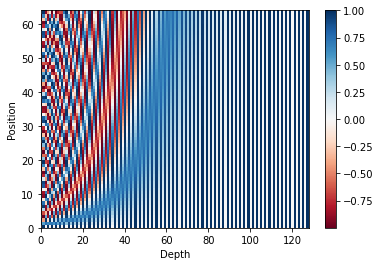

In [16]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print (pos_encoding.shape) # 크기 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

위에서 구한 결괴를 그래프로 출력하면 아래와 같이 각 position 별로 다른 값을 갖는 것을 확인 할 수 있습니다.